In [15]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [16]:
# jax packages
import itertools
import os
import sys
from argparse import ArgumentParser
from functools import partial

import chex
import jax
import jax.numpy as jnp
import numpy as np

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
%matplotlib inline
sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

# logging
import tqdm
import wandb
from celluloid import Camera
from jax import device_put, random
from jax.config import config
from pyprojroot import here
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from wandb.sdk import wandb_config

# library functions
from rbig_jax.models.gaussflow import GaussianizationFlow, init_default_gf_model

# import chex
config.update("jax_enable_x64", False)


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

In [17]:


# ==========================
# PARAMETERS
# ==========================

parser = ArgumentParser(
    description="2D Data Demo with Iterative Gaussianization method"
)

# ======================
# Dataset
# ======================
from rbig_jax.data import add_dataset_args

parser = add_dataset_args(parser)


# ======================
# Preprocessing
# ======================
parser.add_argument(
    "--standardize", type=bool, default=True, help="Standardize Input Training Data"
)

# ======================
# Model
# ======================
from rbig_jax.models.gaussflow import add_gf_model_args

parser = add_gf_model_args(parser)

# ======================
# Model Training
# ======================
from rbig_jax.training.parametric import add_gf_train_args

parser = add_gf_train_args(parser)

# ======================
# Logger Parameters
# ======================
parser.add_argument("--wandb-entity", type=str, default="ipl_uv")
parser.add_argument("--wandb-project", type=str, default="gf_2d_data")
# =====================
# Testing
# =====================
parser.add_argument(
    "-sm",
    "--smoke-test",
    action="store_true",
    help="to do a smoke test without logging",
)






_StoreTrueAction(option_strings=['-sm', '--smoke-test'], dest='smoke_test', nargs=0, const=True, default=False, type=None, choices=None, help='to do a smoke test without logging', metavar=None)

In [18]:
# args = parser.parse_args()
args, _ = parser.parse_known_args()

args.dataset = "checkerboard"
args.smoke_test = False
# change this so we don't bug wandb with our BS
if args.smoke_test:
    os.environ["WANDB_MODE"] = "dryrun"
    args.epochs = 1
    args.n_samples = 1_000

In [19]:
# ==========================
# INITIALIZE LOGGER
# ==========================

wandb_logger = wandb.init(project=args.wandb_project, entity=args.wandb_entity)
wandb_logger.config.update(args)
seed = wandb_logger.config.seed

train_loss_batch,nan
epoch,0
_runtime,86
_timestamp,1619528800
_step,49
train_loss,nan
valid_loss_batch,nan
valid_loss,nan


train_loss_batch,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,
valid_loss_batch,
valid_loss,


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
# ==========================
#  LOAD DATA
# ==========================

# get data
n_samples = wandb_logger.config.n_samples
n_features = 2

if wandb_logger.config.dataset in ["noisysine"]:
    from rbig_jax.data import NoisySineDataset as PlaneDataset

elif wandb_logger.config.dataset in ["s_curve"]:
    from rbig_jax.data import SCurveDataset as PlaneDataset

elif wandb_logger.config.dataset in ["moons"]:
    from rbig_jax.data import MoonsDataset as PlaneDataset

elif wandb_logger.config.dataset in ["swiss_roll"]:
    from rbig_jax.data import SwissRollDataset as PlaneDataset

elif wandb_logger.config.dataset in ["blobs"]:
    from rbig_jax.data import BlobsDataset as PlaneDataset
elif wandb_logger.config.dataset in ["checkerboard"]:
    from rbig_jax.data import CheckBoard as PlaneDataset
else:
    raise ValueError(f"Unrecognized dataset: {wandb_logger.config.dataset}")

In [21]:


n_train = args.n_train
n_train = 5_000
n_valid = args.n_valid
noise = args.noise
seed = args.seed

# initialize dataset
ds_train = PlaneDataset(n_samples=n_train, noise=noise, seed=seed)
ds_valid = PlaneDataset(n_samples=n_valid, noise=noise, seed=seed + 1)
ds_plot = PlaneDataset(n_samples=1_000_000, noise=noise, seed=seed + 2)

# ==========================
# Train-Test Split
# ==========================
from torch.utils.data import DataLoader

# initialize dataloader
batch_size = 128
shuffle = True

train_dl = DataLoader(
    ds_train, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)
valid_dl = DataLoader(
    ds_valid, batch_size=batch_size, shuffle=False, collate_fn=None, num_workers=0
)


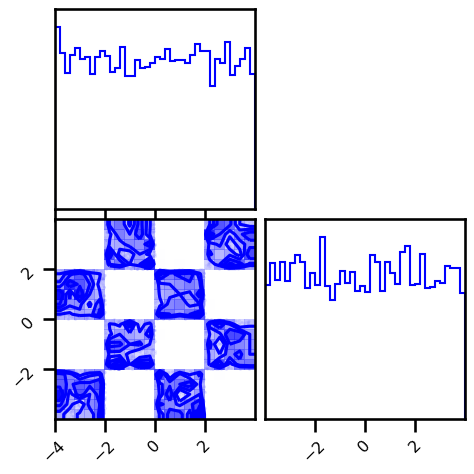

In [22]:

# ==========================
#  PLOTTING
# ==========================

# plot data

fig = corner.corner(ds_train[:], color="blue", hist_bin_factor=2)
plt.show()
# wandb.log({"original_data": wandb.Image(plt)})

In [29]:
# ==========================
#  BUILD MODEL
# ==========================
if args.n_init_samples < len(ds_train):
    X_init = ds_train[: args.n_init_samples]
else:
    X_init = ds_train[:]

# n_blocks = args.n_blocks
n_blocks = 5
n_components = args.n_components
n_reflections = args.n_reflections
n_reflections = 10
mixture = args.mixture
mixture = "logistic"
inverse_cdf = args.inverse_cdf
inverse_cdf = "logistic"
init_mixcdf = args.init_mixcdf
init_mixcdf = "kmeans"

# initialize Model
gf_model = init_default_gf_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=args.n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=args.init_rotation,
    n_reflections=n_reflections,
    plot_layers=False,
    plot_blocks=False,
)


Initializing - Block: 5 | Layer 14: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


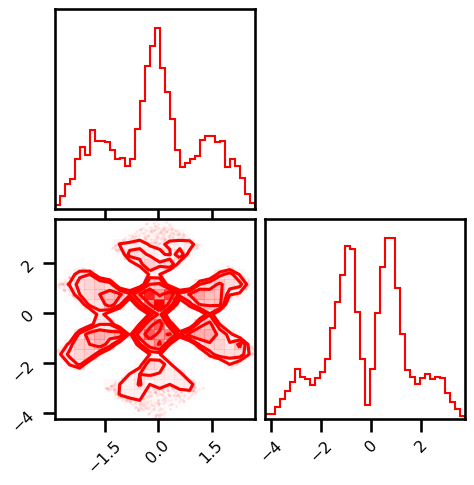

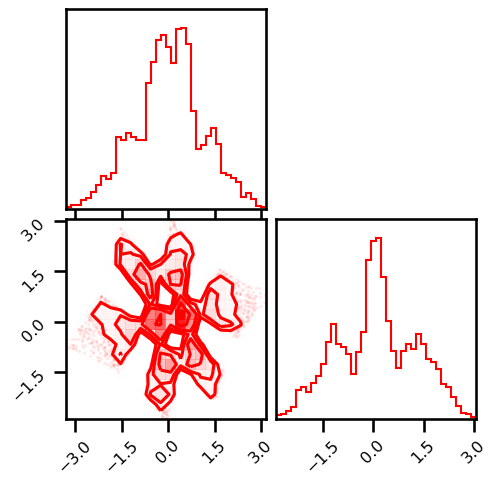

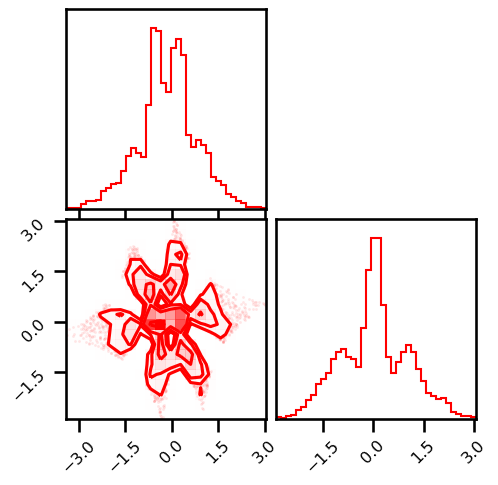

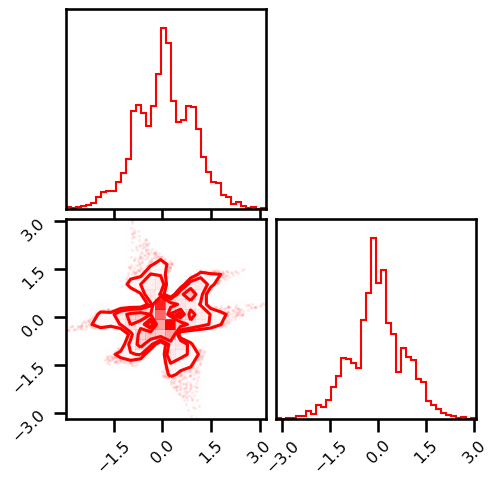

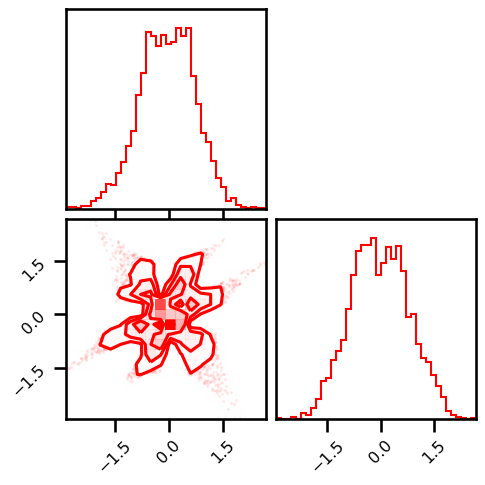

In [30]:
X_g = ds_train[:].copy()

for ibijector in gf_model.bijectors:

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)
        plt.show()
        plt.close("all")

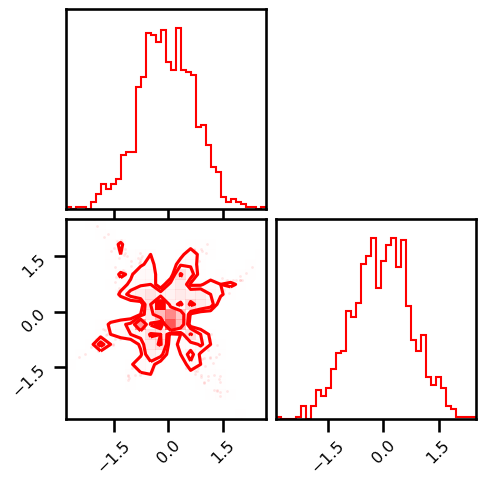

In [31]:

# ==========================
#  PLOTTING
# ==========================
Z = gf_model.forward(X_init)

fig = corner.corner(Z, color="red", hist_bin_factor=2)
# wandb.log({"initial_latent": wandb.Image(plt)})
plt.show()
plt.close('all')

In [32]:

# ==========================
#  TRAINING
# ==========================

from jax.experimental import optimizers

lr = args.lr

lr = 0.05

import optax
opt_init, opt_update = optax.chain(
  # Set the parameters of Adam. Note the learning_rate is not here.
  optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8),
  # Put a minus sign to *minimise* the loss.
  optax.scale(-lr)
)
# if args.optimizer == "adam":

#     optimizer = optimizers.adam(step_size=lr)
# elif args.optimizer == "sgd":
#     optimizer = optimizers.adam(step_size=lr)
# else:
#     raise ValueError(f"Unrecognized optimizer: {args.optimizer}")

# unpack optimizer params
# opt_init, opt_update, get_params = optimizer

# initialize parameters
opt_state = opt_init(gf_model)

# define loss function
def loss_f(gf_model, inputs):
    return gf_model.score(inputs)


In [33]:
# ================================
# Boilerplate Code for Training
# ================================

# # create training loops
# def train_op(i, opt_state, inputs):
#     # get the parameters from the state
#     params = get_params(opt_state)

#     # calculate the loss AND the gradients
#     loss, gradients = jax.value_and_grad(loss_f)(params, inputs)

#     # return loss AND new opt_state
#     return loss, opt_update(i, gradients, opt_state)

def train_op(params, opt_state, inputs):
    
    # Compute gradient and loss.
    loss, gradients = jax.value_and_grad(loss_f)(params, inputs)
    
    # Transform the gradients using the optimiser.
    updates, opt_state = opt_update(gradients, opt_state, params)
    
    # update parameters
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state


train_op = jax.jit(train_op)

In [ ]:
%%wandb



# ================================
# TRAINING
# ================================
import jax.numpy as jnp

train_losses = list()
valid_losses = list()
itercount = itertools.count()
train_batch_loss = 0.0
valid_batch_loss = 0.0
interval = 5

pbar = tqdm.trange(args.epochs)

with pbar:
    for i_epoch in pbar:

        # Train
        avg_loss = []

        for ix in train_dl:

            # cast to jax array
            ix = jnp.array(ix, dtype=jnp.float32)

            # compute loss
            loss, gf_model, opt_state = train_op(gf_model, opt_state, ix)

            # append batch
            wandb.log({"train_loss_batch": float(loss), "epoch": i_epoch})
            avg_loss.append(float(loss))

        # average loss
        train_batch_loss = jnp.mean(jnp.stack(avg_loss))
        wandb.log({"train_loss": float(train_batch_loss), "epoch": i_epoch})

        # Log losses
        train_losses.append(np.array(train_batch_loss))
        pbar.set_postfix(
            {
                "Train Loss": f"{train_batch_loss:.4f}",
                "Valid Loss": f"{valid_batch_loss:.4f}",
            }
        )

        if valid_dl is not None:

#             final_params = get_params(opt_state)

            # Train
            avg_loss = []

            for ix in valid_dl:

                # cast to jax array
                ix = jnp.array(ix, dtype=jnp.float32)

                # compute loss
                loss = gf_model.score(ix)

                # append batch
                wandb.log({"valid_loss_batch": float(loss), "epoch": i_epoch})
                avg_loss.append(float(loss))

            # average loss
            valid_batch_loss = jnp.mean(jnp.stack(avg_loss))
            wandb.log({"valid_loss": float(valid_batch_loss), "epoch": i_epoch})

            valid_losses.append(np.array(valid_batch_loss))

            pbar.set_postfix(
                {
                    "Train Loss": f"{train_batch_loss:.4f}",
                    "Valid Loss": f"{valid_batch_loss:.4f}",
                }
            )

        else:
            continue

        if i_epoch % interval == 0:
            X_trans = []
            for ix in train_dl:

                # cast to jax array
                ix = jnp.array(ix, dtype=jnp.float32)

                ix = gf_model.forward(ix)

                X_trans.append(ix)

            X_trans = jnp.concatenate(X_trans, axis=0)
            fig = corner.corner(np.array(X_trans), color="Red")
            wandb.log({"training_latent_space": wandb.Image(plt), "epoch": i_epoch})
            plt.close('all')

 37%|███▋      | 37/100 [05:59<08:54,  8.48s/it, Train Loss=4.1158, Valid Loss=4.4305] 

In [23]:
# final_bijector = get_params(opt_state)


# ==========================
#  Score
# ==========================
nll_loss = gf_model.score(ds_train[:])

wandb.log({"nll_loss": np.array(nll_loss)})



In [24]:
nll_loss

DeviceArray(1.4613056, dtype=float32)

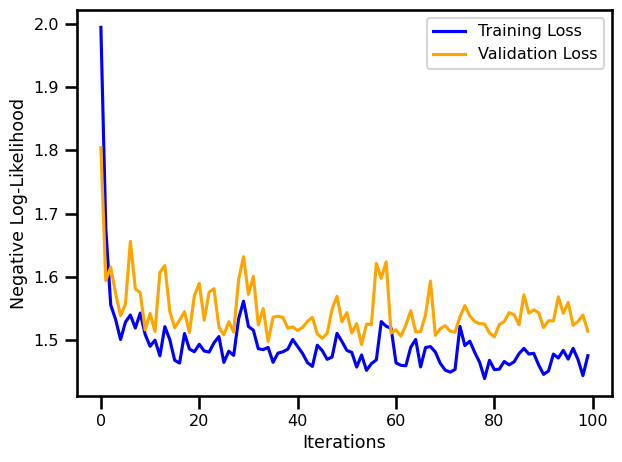

In [25]:
# ==========================
#  PLOTTING
# ==========================
train_losses = jnp.stack(train_losses)
if valid_dl is not None:
    valid_losses = jnp.stack(valid_losses)
else:
    valid_losses = None
losses = {"train": train_losses, "valid": valid_losses}


fig, ax = plt.subplots()
ax.plot(losses["train"], label="Training Loss", color="blue")
ax.plot(losses["valid"], label="Validation Loss", color="orange")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()
# wandb.log({"final_losses": wandb.Image(plt)})


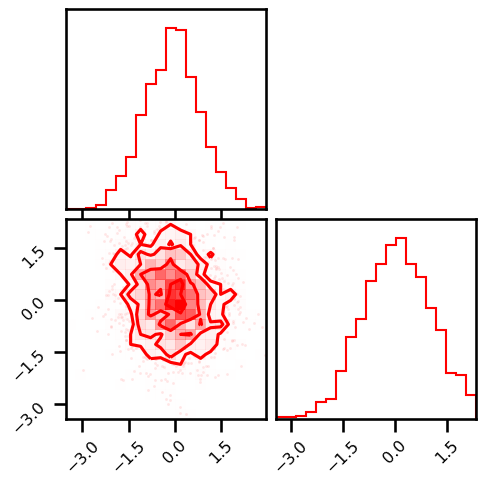

In [29]:
# =========================
# PLOTS
# =========================

# LATENT SPACE
X_trans = gf_model.forward(ds_train[:])

fig = corner.corner(X_trans, color="Red")
# wandb.log({"final_latent_space": wandb.Image(plt)})
plt.show()
plt.close("all")




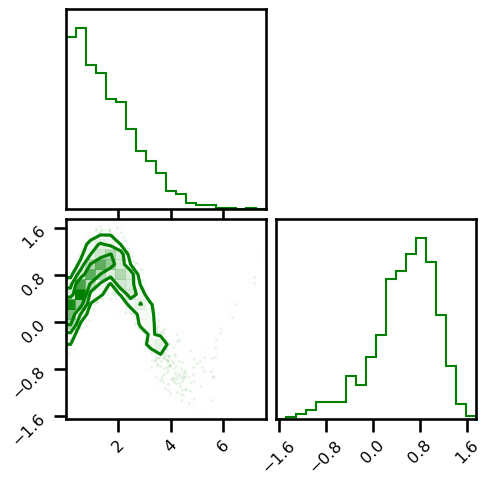

In [30]:
# INVERSE TRANSFORM
X_approx = gf_model.inverse(X_trans)

fig = corner.corner(X_approx, color="green")
# wandb.log({"inverse_space": wandb.Image(plt)})
plt.show()
plt.close("all")



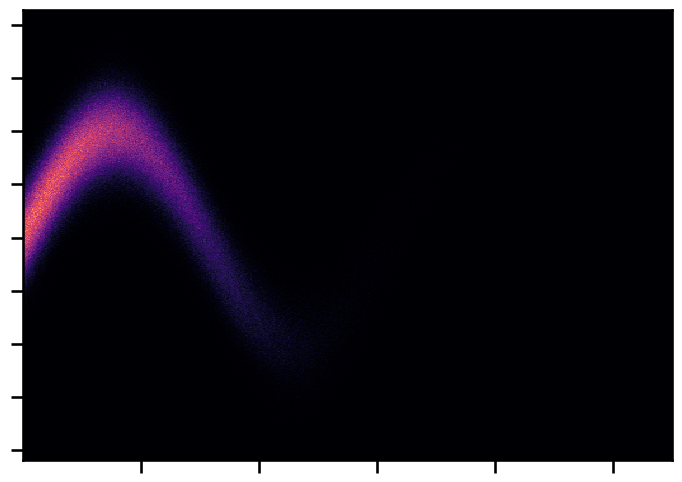

In [31]:
# LOG PROBABILITY
from rbig_jax.data import generate_2d_grid

cmap = cm.magma  # "Reds"
X_plot = ds_plot[:]

fig, ax = plt.subplots(figsize=(7, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.tight_layout()
# wandb.log({"original_density": wandb.Image(plt)})
plt.show()
plt.close("all")


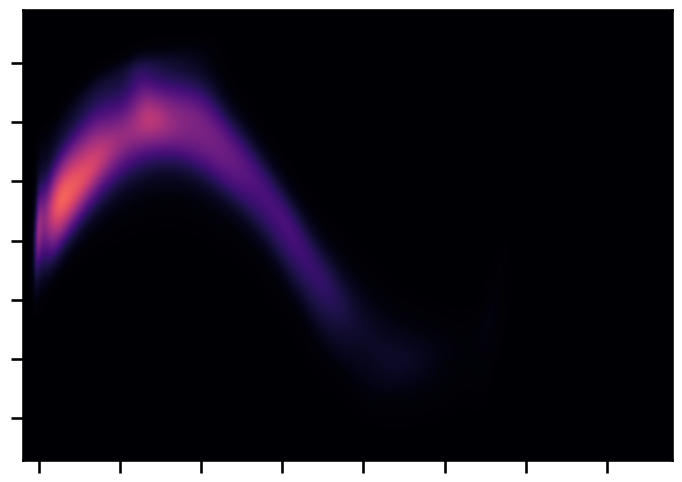

In [33]:


# generate grid points
xyinput = generate_2d_grid(ds_train[:], 500, buffer=0.2)

# calculate log probability
X_log_prob = gf_model.score_samples(xyinput)

X_plot = ds_plot[:]

# Estimated Density

probs = jnp.exp(X_log_prob)

fig, ax = plt.subplots(figsize=(7, 5))
h = ax.scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.tight_layout()
# wandb.log({"estimated_density": wandb.Image(plt)})
plt.show()
plt.close("all")


In [35]:
# =======================
# Save Model
# =======================
import joblib

model_save_name = os.path.join(wandb.run.dir, "trained_model.pckl")
joblib.dump(gf_model, model_save_name)
wandb.save(model_save_name)

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/home/emmanuel/code/rbig_jax/jupyterbook/content/experimental/plane/wandb/run-20210427_140431-wtzdttvr/files/trained_model.pckl',
 '/home/emmanuel/code/rbig_jax/jupyterbook/content/experimental/plane/wandb/run-20210427_140431-wtzdttvr/files/trained_model.pckl']